In [2]:
# ส่วนที่ 1 - การเตรียมข้อมูล:
import pandas as pd

# โหลดข้อมูล
file_path = 'export-4B7B6566022D-1d.xlsx'
dataset = pd.read_excel(file_path, engine="openpyxl")

# ลบแถวที่มีค่า NaN
dataset = dataset.dropna()

# เลือกเฉพาะคอลัมน์ที่เป็นตัวเลข
numeric_cols = dataset.select_dtypes(include=['number']).columns

# คำนวณ IQR สำหรับทุกคอลัมน์
Q1 = dataset[numeric_cols].quantile(0.25)
Q3 = dataset[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# คำนวณขอบเขตของค่า Outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# กำจัดค่า Outlier
mask = ~((dataset[numeric_cols] < lower_bound) | (dataset[numeric_cols] > upper_bound)).any(axis=1)
cleaned_dataset = dataset.loc[mask]

# บันทึกข้อมูลที่ถูกล้างแล้วเป็นไฟล์ใหม่
output_path = 'cleaned_data.xlsx'
cleaned_dataset.to_excel(output_path, index=False)

# รายงานผล
num_removed = len(dataset) - len(cleaned_dataset)
print(f"ข้อมูลหลังทำความสะอาดเหลือ {len(cleaned_dataset)} แถว จากเดิม {len(dataset)} แถว (ลบไป {num_removed} แถว)")

ข้อมูลหลังทำความสะอาดเหลือ 581 แถว จากเดิม 605 แถว (ลบไป 24 แถว)


In [3]:
# ส่วนที่ 2 - การสร้างคุณลักษณะและตั้งค่า PyCaret:
import pandas as pd
from pycaret.regression import *

# โหลดข้อมูลจากไฟล์ Excel
dataset = pd.read_excel('cleaned_data.xlsx')

# เตรียมข้อมูล
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'], errors='coerce')
dataset.dropna(subset=['timestamp'], inplace=True)

# สร้างคุณลักษณะเกี่ยวกับเวลา
dataset['day'] = dataset['timestamp'].dt.day
dataset['month'] = dataset['timestamp'].dt.month
dataset['hour'] = dataset['timestamp'].dt.hour
dataset['dayofweek'] = dataset['timestamp'].dt.dayofweek

# สร้าง Lag Features สำหรับอุณหภูมิ
for lag in range(1, 8):  
    dataset[f'temperature_lag_{lag}'] = dataset['temperature'].shift(lag * 24)

# สร้าง Rolling Mean และ Rolling Rate สำหรับอุณหภูมิ
for window in [3, 7]:
    dataset[f'temperature_roll_mean_{window}'] = dataset['temperature'].rolling(window=window * 24).mean()
    dataset[f'temperature_roll_std_{window}'] = dataset['temperature'].rolling(window=window * 24).std()
    dataset[f'temperature_roll_rate_{window}'] = dataset[f'temperature_roll_mean_{window}'].pct_change() * 100

# เพิ่มความชื้นและ PM2.5 เป็นตัวแปรช่วย
for lag in [1, 2]:
    dataset[f'humidity_lag_{lag}'] = dataset['humidity'].shift(lag * 24)
    dataset[f'pm_2_5_lag_{lag}'] = dataset['pm_2_5'].shift(lag * 24)

# ลบแถวที่มีค่า NaN
dataset.dropna(inplace=True)

# เลือกคอลัมน์ที่ใช้
features = (
    ['humidity', 'pm_2_5', 'hour', 'day', 'month', 'dayofweek'] + 
    [f'temperature_lag_{lag}' for lag in range(1, 8)] + 
    [f'temperature_roll_mean_{window}' for window in [3, 7]] +
    [f'temperature_roll_std_{window}' for window in [3, 7]] +
    [f'temperature_roll_rate_{window}' for window in [3, 7]] +
    [f'humidity_lag_{lag}' for lag in [1, 2]] +
    [f'pm_2_5_lag_{lag}' for lag in [1, 2]]
)
target = 'temperature'
dataset_filtered = dataset[features + [target]]

# ตั้งค่า PyCaret
setup(data=dataset_filtered, target=target, fold=10, train_size=0.8, session_id=123, remove_outliers=True)

# เปรียบเทียบโมเดล
best_model = compare_models()

# ใช้ฟังก์ชัน evaluate_model เพื่อตรวจสอบโมเดลที่ดีที่สุด
evaluate_model(best_model)

,Description,Value
0,Session id,123
1,Target,temperature
2,Target type,Regression
3,Original data shape,"(413, 24)"
4,Transformed data shape,"(396, 24)"
5,Transformed train set shape,"(313, 24)"
6,Transformed test set shape,"(83, 24)"
7,Numeric features,23
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0223,0.0009,0.0296,0.9996,0.0010,0.0008,0.3440
br,Bayesian Ridge,0.0225,0.0009,0.0297,0.9996,0.0010,0.0008,0.0170
gbr,Gradient Boosting Regressor,0.2752,0.1267,0.3503,0.9438,0.0119,0.0097,0.0400
lightgbm,Light Gradient Boosting Machine,0.2924,0.1379,0.3644,0.9401,0.0125,0.0103,0.0420
et,Extra Trees Regressor,0.3193,0.1702,0.4089,0.9240,0.0140,0.0113,0.0400
rf,Random Forest Regressor,0.3639,0.2274,0.4700,0.8998,0.0161,0.0128,0.0550
ada,AdaBoost Regressor,0.4216,0.2845,0.5290,0.8736,0.0180,0.0148,0.0290
ridge,Ridge Regression,0.4107,0.2855,0.5306,0.8714,0.0180,0.0144,0.0160
dt,Decision Tree Regressor,0.5730,0.5510,0.7367,0.7517,0.0252,0.0202,0.0170
huber,Huber Regressor,0.5711,0.5551,0.7388,0.7500,0.0251,0.0201,0.0170


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7989,1.0429,1.0212,0.6261,0.0347,0.0282
1,0.6544,0.6828,0.8263,0.6386,0.0278,0.0229
2,0.7223,0.9327,0.9657,0.6549,0.0330,0.0256
3,0.7412,0.7728,0.8791,0.7034,0.0300,0.0262
4,0.6855,0.7698,0.8774,0.6802,0.0301,0.0245
5,0.6881,0.8233,0.9073,0.6750,0.0315,0.0246
6,0.5318,0.4368,0.6609,0.7533,0.0222,0.0186
7,0.6508,0.7015,0.8375,0.6664,0.0278,0.0222
8,0.5406,0.4516,0.6720,0.7785,0.0231,0.0192


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3924,0.3082,0.5551,0.8895,0.0191,0.0138
1,0.3632,0.2285,0.4780,0.8791,0.0164,0.0128
2,0.5187,0.3868,0.6219,0.8569,0.0212,0.0183
3,0.4287,0.2870,0.5357,0.8899,0.0182,0.0151
4,0.3968,0.2473,0.4973,0.8973,0.0170,0.0141
5,0.4026,0.2818,0.5308,0.8887,0.0186,0.0144
6,0.3548,0.1640,0.4050,0.9073,0.0136,0.0124
7,0.3537,0.2055,0.4533,0.9023,0.0154,0.0123
8,0.2977,0.1461,0.3823,0.9283,0.0133,0.0106


Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

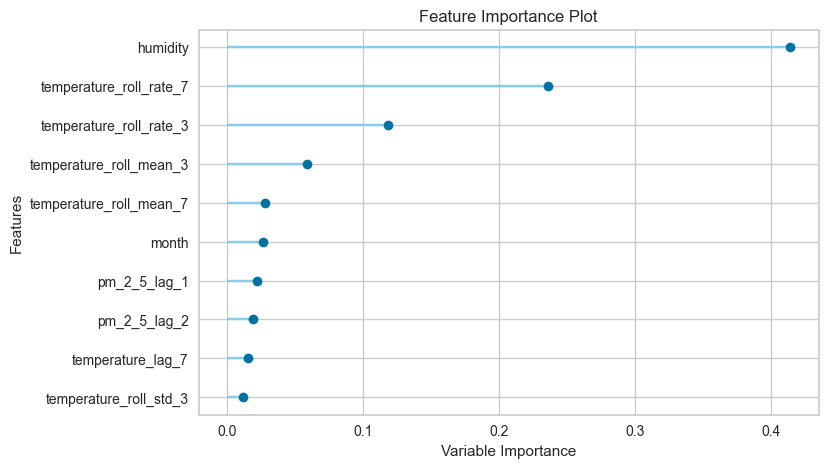

In [ ]:
# เลือกโมเดล Extra Trees พร้อมกับปรับพารามิเตอร์เพื่อลด Overfitting
et_model = create_model('et', 
                       min_samples_leaf=10,
                       min_samples_split=20, 
                       max_depth=15,
                       max_features='sqrt',
                       n_estimators=100)

# ปรับพารามิเตอร์ของโมเดลด้วยการระบุค่าที่ช่วยป้องกัน Overfitting
tuned_model = tune_model(et_model, 
                       custom_grid={
                           'min_samples_leaf': [5, 10, 20],
                           'min_samples_split': [10, 20, 30],
                           'max_depth': [10, 15, 20, None],
                           'max_features': ['sqrt', 'log2', None],
                           'n_estimators': [50, 100, 150]
                       })

# ประเมินโมเดลที่ปรับพารามิเตอร์แล้ว
evaluate_model(tuned_model)

# แสดงคุณลักษณะที่สำคัญที่สุดเพื่อพิจารณาการลดจำนวนคุณลักษณะ
plot_model(tuned_model, plot='feature')

In [5]:
# ส่วนที่ 4 - การสร้างโมเดลสุดท้าย:
final_model = finalize_model(tuned_model)
save_model(final_model, 'temperature_forecast_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['humidity', 'pm_2_5', 'hour',
                                              'day', 'month', 'dayofweek',
                                              'temperature_lag_1',
                                              'temperature_lag_2',
                                              'temperature_lag_3',
                                              'temperature_lag_4',
                                              'temperature_lag_5',
                                              'temperature_lag_6',
                                              'temperature_lag_7',
                                              'temperature_roll_mean_3',
                                              'temperature_roll_mean_7',
                                              'temperatur...
                                     transformer=SimpleImputer())),
                 ('categor

In [9]:
# ส่วนที่ 5 - การทำนายค่าอุณหภูมิในอนาคต:
# สร้าง future_df สำหรับการทำนาย 7 วันข้างหน้า
last_timestamp = dataset['timestamp'].max()
future_dates = pd.date_range(start=last_timestamp + pd.Timedelta(days=1), periods=7, freq='D')

# ใช้ค่าเฉลี่ยของ 30 วันล่าสุดสำหรับ humidity และ pm_2_5
recent_data = dataset.sort_values('timestamp').tail(30 * 24)  # 30 วันล่าสุด
avg_humidity = recent_data['humidity'].mean()
avg_pm25 = recent_data['pm_2_5'].mean()

# ดึงค่าอุณหภูมิล่าสุดสำหรับสร้าง features
latest_temp_values = dataset.sort_values('timestamp').tail(7 * 24)['temperature'].tolist()
latest_temp_values.reverse()  # กลับลำดับเพื่อให้ค่าล่าสุดอยู่ที่ดัชนี 0

latest_humidity_values = dataset.sort_values('timestamp').tail(2 * 24)['humidity'].tolist()
latest_humidity_values.reverse()

latest_pm25_values = dataset.sort_values('timestamp').tail(2 * 24)['pm_2_5'].tolist()
latest_pm25_values.reverse()

# ทำนายทีละวัน
predictions = []
current_data = dataset.copy().sort_values('timestamp')

for i, date in enumerate(future_dates):
    # สร้างข้อมูลพื้นฐานสำหรับวันใหม่
    new_day = pd.DataFrame({
        'timestamp': [date],
        'humidity': [avg_humidity],
        'pm_2_5': [avg_pm25],
        'day': [date.day],
        'month': [date.month],
        'hour': [12],  # ใช้เวลาเที่ยงวันเป็นตัวแทนของวัน
        'dayofweek': [date.dayofweek]
    })

    # สร้าง lag features สำหรับอุณหภูมิ
    for lag in range(1, 8):
        if i >= lag:
            # ใช้ค่าที่ทำนายไปแล้วสำหรับวันที่ผ่านมา
            new_day[f'temperature_lag_{lag}'] = [predictions[i - lag]]
        else:
            # ใช้ค่าจริงจากชุดข้อมูล
            lag_idx = lag - i - 1
            if abs(lag_idx) < len(latest_temp_values):
                new_day[f'temperature_lag_{lag}'] = [latest_temp_values[lag_idx]]
            else:
                new_day[f'temperature_lag_{lag}'] = [latest_temp_values[-1]]  # ใช้ค่าสุดท้ายที่มี
    
    # สร้าง lag features สำหรับความชื้นและ PM2.5
    for lag in [1, 2]:
        if i >= lag:
            # สมมติว่าความชื้นและ PM2.5 คงที่
            new_day[f'humidity_lag_{lag}'] = [avg_humidity]
            new_day[f'pm_2_5_lag_{lag}'] = [avg_pm25]
        else:
            # ใช้ค่าจริงจากชุดข้อมูล
            h_lag_idx = lag - i - 1
            if abs(h_lag_idx) < len(latest_humidity_values):
                new_day[f'humidity_lag_{lag}'] = [latest_humidity_values[h_lag_idx]]
            else:
                new_day[f'humidity_lag_{lag}'] = [latest_humidity_values[-1]]
                
            pm_lag_idx = lag - i - 1
            if abs(pm_lag_idx) < len(latest_pm25_values):
                new_day[f'pm_2_5_lag_{lag}'] = [latest_pm25_values[pm_lag_idx]]
            else:
                new_day[f'pm_2_5_lag_{lag}'] = [latest_pm25_values[-1]]

    # คำนวณ rolling metrics สำหรับอุณหภูมิ
    for window in [3, 7]:
        if i == 0:
            # ใช้ค่าจาก window วันล่าสุดในชุดข้อมูล
            last_n_days = latest_temp_values[:window]
            roll_mean = sum(last_n_days) / len(last_n_days)
            roll_std = sum((x - roll_mean) ** 2 for x in last_n_days) ** 0.5 / len(last_n_days) if len(last_n_days) > 1 else 0
            
            # คำนวณ roll_rate
            prev_window = latest_temp_values[1:window+1]
            prev_roll_mean = sum(prev_window) / len(prev_window) if prev_window else roll_mean
            roll_rate = ((roll_mean - prev_roll_mean) / prev_roll_mean) * 100 if prev_roll_mean != 0 else 0
            
            new_day[f'temperature_roll_mean_{window}'] = [roll_mean]
            new_day[f'temperature_roll_std_{window}'] = [roll_std]
            new_day[f'temperature_roll_rate_{window}'] = [roll_rate]
        else:
            # ใช้ค่าที่ทำนายไปแล้ว
            recent_values = predictions[-window:] if len(predictions) >= window else predictions + latest_temp_values[:window-len(predictions)]
            roll_mean = sum(recent_values) / len(recent_values)
            roll_std = sum((x - roll_mean) ** 2 for x in recent_values) ** 0.5 / len(recent_values) if len(recent_values) > 1 else 0
            
            # คำนวณ roll_rate
            if len(predictions) >= window + 1:
                prev_values = predictions[-(window+1):-1]
            else:
                prev_values = predictions[:-1] + latest_temp_values[:window-len(predictions)+1] if len(predictions) > 0 else latest_temp_values[:window]
            
            prev_roll_mean = sum(prev_values) / len(prev_values) if prev_values else roll_mean
            roll_rate = ((roll_mean - prev_roll_mean) / prev_roll_mean) * 100 if prev_roll_mean != 0 else 0
            
            new_day[f'temperature_roll_mean_{window}'] = [roll_mean]
            new_day[f'temperature_roll_std_{window}'] = [roll_std]
            new_day[f'temperature_roll_rate_{window}'] = [roll_rate]

    # ทำนายค่าอุณหภูมิ
    prediction = predict_model(final_model, data=new_day)
    predicted_value = prediction.iloc[0]['prediction_label']
    predictions.append(predicted_value)

    # เพิ่มข้อมูลที่ทำนายแล้วลงใน current_data
    new_row = new_day.copy()
    new_row['temperature'] = predicted_value
    current_data = pd.concat([current_data, new_row], ignore_index=True)

# สร้าง DataFrame สำหรับผลลัพธ์
result_df = pd.DataFrame({
    'timestamp': future_dates,
    'predicted_temperature': predictions
})

print("ผลลัพธ์การทำนายอุณหภูมิ:")
print(result_df)

ผลลัพธ์การทำนายอุณหภูมิ:
            timestamp  predicted_temperature
0 2025-02-06 07:00:00              29.000113
1 2025-02-07 07:00:00              29.318028
2 2025-02-08 07:00:00              29.717817
3 2025-02-09 07:00:00              29.799585
4 2025-02-10 07:00:00              29.901324
5 2025-02-11 07:00:00              29.986656
6 2025-02-12 07:00:00              30.172044


In [10]:
# ส่วนที่ 6 - การสร้างกราฟแสดงผลการทำนาย:
import plotly.graph_objects as go

# สร้างกราฟ
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=result_df['timestamp'],
    y=result_df['predicted_temperature'],
    mode='lines+markers',
    name='Predicted Temperature',
    marker=dict(color='rgba(255, 99, 132, 0.8)'),
    line=dict(width=2)
))

fig.update_layout(
    title='Temperature Forecast for the Next 7 Days',  # แก้ไขตรงนี้ - เพิ่มเครื่องหมายคำพูดปิด
    xaxis_title='Date',
    yaxis_title='Temperature (°C)',
    paper_bgcolor='white',
    plot_bgcolor='white'
)

fig.show()

In [11]:
# ส่วนที่ 7 - การประเมินประสิทธิภาพของโมเดล:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# สำหรับการประเมินโมเดล คุณควรทำการแบ่งข้อมูลเป็นชุดฝึกสอนและชุดทดสอบตั้งแต่แรก
# ตัวอย่างการประเมินโมเดลโดยใช้ข้อมูล 7 วันสุดท้ายเป็นชุดทดสอบ

# สร้างชุดทดสอบ (ตัวอย่าง: 7 วันสุดท้ายในชุดข้อมูล)
test_data = dataset.sort_values('timestamp').tail(7)

# ถ้าคุณได้ทำนายค่าอุณหภูมิในช่วงเวลาเดียวกันกับชุดทดสอบ
# คำนวณค่าความคลาดเคลื่อน
true_values = test_data['temperature'].values
predicted_values = result_df['predicted_temperature'].values  # สมมติว่าคุณได้ทำนายค่าเดียวกันนี้

# คำนวณค่าความคลาดเคลื่อน
mae = mean_absolute_error(true_values, predicted_values)
mse = mean_squared_error(true_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(true_values, predicted_values)

# แสดงผลลัพธ์
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# หมายเหตุ: วิธีที่ถูกต้องกว่าคือการแบ่งข้อมูลเป็นชุดฝึกสอนและชุดทดสอบก่อนสร้างโมเดล
# ตัวอย่างการทำแบบถูกต้อง:



Mean Absolute Error (MAE): 2.63
Mean Squared Error (MSE): 7.57
Root Mean Squared Error (RMSE): 2.75
R² Score: -6.86
